In [1]:
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


Mounted at /content/drive


In [2]:
# List contents of My Drive
drive_path = '/content/drive/MyDrive/archive'
os.listdir(drive_path)

['HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'SequentialCNNandLatentNet.ipynb',
 'DenseNet.ipynb',
 'Copy of DenseNet.ipynb']

In [3]:
# Assuming data.csv is in the same folder as your Colab notebook
file_path = '/content/drive/MyDrive/archive/HAM10000_metadata.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
base_skin_dir = '/content/drive/MyDrive/archive/'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [6]:
# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2


In [8]:
# Data Cleaning
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [9]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [16]:
# Data preprocessing
df_original = pd.read_csv('/content/drive/MyDrive/archive/HAM10000_metadata.csv')
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

# Split into train, test, and val
df_train, df_test = train_test_split(df_original, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [18]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [19]:
# resnet and densenet
model_name = 'densenet'
num_classes = 7
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 78.1MB/s]


In [20]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor()])#, transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor()]),
                                    #transforms.Normalize(norm_mean, norm_std)])

In [21]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        try:
            # Load data and get label
            X = Image.open(self.df['path'][index])
            y = torch.tensor(int(self.df['cell_type_idx'][index]))

            if self.transform:
                X = self.transform(X)

            return X, y
        except KeyError as e:
            print(f"KeyError at index {index}: {e}")
            return None, None
        except Exception as e:
            print(f"Error loading data at index {index}: {e}")
            return None, None


In [22]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [24]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [26]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [27]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * (input_size // 8) * (input_size // 8), 512)
        self.relu_fc1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the simple CNN model
model = SimpleCNN(num_classes=num_classes)
model = model.to(device)


In [29]:
from tqdm import tqdm

# Define the device:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training loop
epoch_num = 10
best_val_acc = 0
total_loss_train, total_acc_train = [], []
total_loss_val, total_acc_val = [], []

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

for epoch in tqdm(range(1, epoch_num + 1)):
    # Training
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()

    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)

        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / N)
        train_loss.update(loss.item())

        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))

    total_loss_train.append(train_loss.avg)
    total_acc_train.append(train_acc.avg)

    print('[epoch %d], [train loss %.5f], [train acc %.5f]' % (epoch, train_loss.avg, train_acc.avg))

    # Validation
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)

            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / N)
            val_loss.update(criterion(outputs, labels).item())

    total_loss_val.append(val_loss.avg)
    total_acc_val.append(val_acc.avg)

    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))

    if val_acc.avg > best_val_acc:
        best_val_acc = val_acc.avg
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
        print('*****************************************************')

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 226], [train loss 1.12531], [train acc 0.65281]
[epoch 1], [iter 200 / 226], [train loss 1.04382], [train acc 0.66344]
[epoch 1], [train loss 1.02528], [train acc 0.66748]


 10%|█         | 1/10 [13:43<2:03:30, 823.37s/it]

[epoch 1], [val loss 0.92705], [val acc 0.67548]
*****************************************************
best record: [epoch 1], [val loss 0.92705], [val acc 0.67548]
*****************************************************
[epoch 2], [iter 100 / 226], [train loss 0.91554], [train acc 0.66469]
[epoch 2], [iter 200 / 226], [train loss 0.92085], [train acc 0.67328]
[epoch 2], [train loss 0.91408], [train acc 0.67652]


 20%|██        | 2/10 [15:49<55:05, 413.22s/it]  

[epoch 2], [val loss 0.91361], [val acc 0.69351]
*****************************************************
best record: [epoch 2], [val loss 0.91361], [val acc 0.69351]
*****************************************************
[epoch 3], [iter 100 / 226], [train loss 0.87846], [train acc 0.68563]
[epoch 3], [iter 200 / 226], [train loss 0.89040], [train acc 0.68531]
[epoch 3], [train loss 0.89078], [train acc 0.68526]


 30%|███       | 3/10 [17:56<32:57, 282.52s/it]

[epoch 3], [val loss 0.90373], [val acc 0.70072]
*****************************************************
best record: [epoch 3], [val loss 0.90373], [val acc 0.70072]
*****************************************************
[epoch 4], [iter 100 / 226], [train loss 0.90015], [train acc 0.68219]
[epoch 4], [iter 200 / 226], [train loss 0.88127], [train acc 0.69094]
[epoch 4], [train loss 0.88109], [train acc 0.69154]


 40%|████      | 4/10 [20:03<22:06, 221.02s/it]

[epoch 4], [val loss 0.86533], [val acc 0.71394]
*****************************************************
best record: [epoch 4], [val loss 0.86533], [val acc 0.71394]
*****************************************************
[epoch 5], [iter 100 / 226], [train loss 0.84824], [train acc 0.69937]
[epoch 5], [iter 200 / 226], [train loss 0.84978], [train acc 0.70000]
[epoch 5], [train loss 0.85207], [train acc 0.69693]


 50%|█████     | 5/10 [22:07<15:31, 186.30s/it]

[epoch 5], [val loss 0.86611], [val acc 0.70433]
[epoch 6], [iter 100 / 226], [train loss 0.82434], [train acc 0.69719]
[epoch 6], [iter 200 / 226], [train loss 0.83160], [train acc 0.69984]
[epoch 6], [train loss 0.82824], [train acc 0.69889]


 60%|██████    | 6/10 [24:13<11:02, 165.58s/it]

[epoch 6], [val loss 0.86649], [val acc 0.69832]
[epoch 7], [iter 100 / 226], [train loss 0.83409], [train acc 0.70188]
[epoch 7], [iter 200 / 226], [train loss 0.82545], [train acc 0.70469]
[epoch 7], [train loss 0.81883], [train acc 0.70678]


 70%|███████   | 7/10 [26:17<07:36, 152.10s/it]

[epoch 7], [val loss 0.84052], [val acc 0.71755]
*****************************************************
best record: [epoch 7], [val loss 0.84052], [val acc 0.71755]
*****************************************************
[epoch 8], [iter 100 / 226], [train loss 0.80506], [train acc 0.70969]
[epoch 8], [iter 200 / 226], [train loss 0.81137], [train acc 0.70828]
[epoch 8], [train loss 0.80989], [train acc 0.70821]


 80%|████████  | 8/10 [28:22<04:46, 143.39s/it]

[epoch 8], [val loss 0.83708], [val acc 0.70192]
[epoch 9], [iter 100 / 226], [train loss 0.78525], [train acc 0.71531]
[epoch 9], [iter 200 / 226], [train loss 0.78581], [train acc 0.71500]
[epoch 9], [train loss 0.79038], [train acc 0.71192]


 90%|█████████ | 9/10 [30:27<02:17, 137.57s/it]

[epoch 9], [val loss 0.80576], [val acc 0.70433]
[epoch 10], [iter 100 / 226], [train loss 0.75368], [train acc 0.71625]
[epoch 10], [iter 200 / 226], [train loss 0.75282], [train acc 0.72234]
[epoch 10], [train loss 0.75962], [train acc 0.71925]


100%|██████████| 10/10 [32:33<00:00, 195.36s/it]

[epoch 10], [val loss 0.77002], [val acc 0.71875]
*****************************************************
best record: [epoch 10], [val loss 0.77002], [val acc 0.71875]
*****************************************************


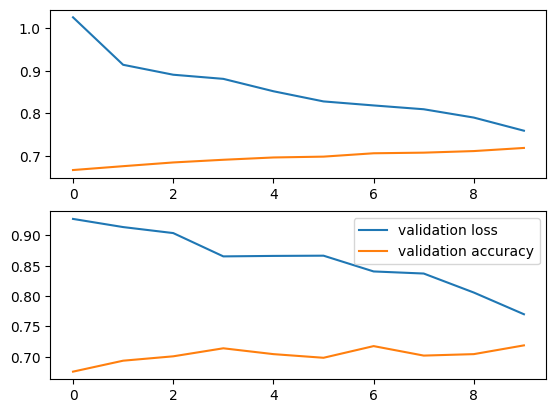

In [30]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

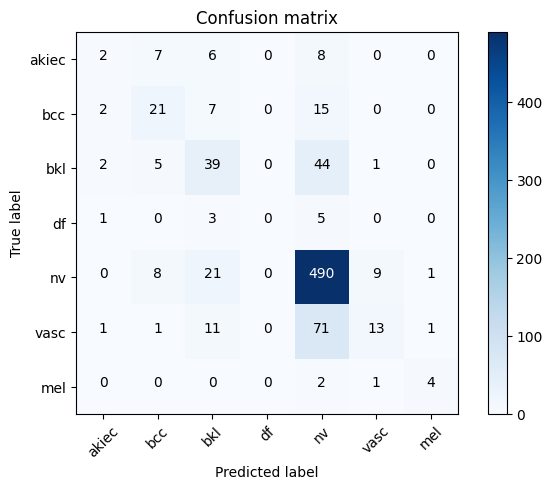

In [32]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(y_label, y_predict)

0.7094763092269327